## Supervised Learning
## Project: Finding Donors for *CharityML*

----
## Exploring the Data


In [16]:
# Importing libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames




# Importing supplementary visualization code visuals.py
import visuals as vs

# Pretty displaying for notebooks
%matplotlib inline

# Loading the Census dataset
data = pd.read_csv("census.csv")

# Success - Displaying the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000.

In [17]:
# Total number of records
n_records = len(data.index)

# Number of records where individual's income is more than $50,000

n_greater_50k = len(data['income'][data['income']=='>50K'])

# Number of records where individual's income is at most $50,000
n_at_most_50k = len(data['income'][data['income']=='<=50K'])

# Percentage of individuals whose income is more than $50,000
greater_percent = round((n_greater_50k/n_records)*100,2)

# Printing the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data


### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

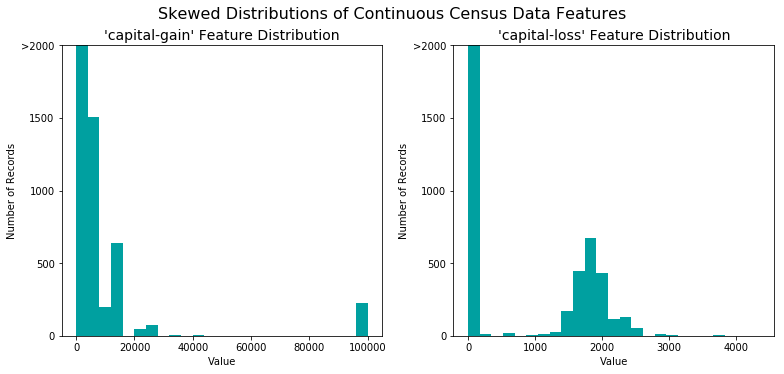

In [18]:
# Splitting the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualizing skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a logarithmic transformation on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers.

Running the code cell below to perform a transformation on the data and visualize the results.

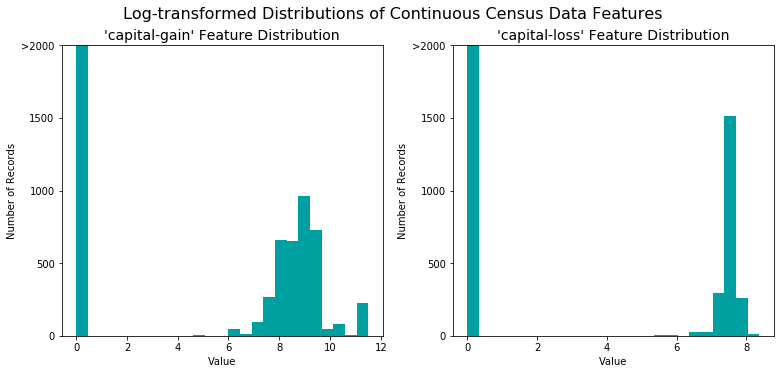

In [19]:
# Log-transforming the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualizing the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners.


In [20]:
# Importing sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initializing a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Showing an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. 

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively.

In [21]:
#  One-hot encoding the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

#  Encoding the 'income_raw' data to numerical values
income = income_raw.astype('category').cat.codes

# Printing the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

# Uncommenting the following line to see the encoded feature names
print(encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffling and Splitting Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. I will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

In [22]:
# Importing train_test_split
from sklearn.cross_validation import train_test_split

# Splitting the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Showing the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, I am investigating four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners that I see fit the data, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. 

Looking at the distribution of classes, those who make at most \$50,000*. and those who make more, it's clear most individuals do not make more than \$50,000 This can greatly affect **accuracy**, since we could simply say *"this person does not make more than $50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for the data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

In [23]:
TP = np.sum(income) 
# Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
#encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case

#  Calculating accuracy, precision and recall
accuracy = (TP+TN)/(TP+FP+TN+FN)
recall =TP/(TP+FN)
precision = TP/(TP+FP)

#  Calculating F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1+0.25)*(precision*recall)/((0.25*precision)+recall)
print(TP,FP)
# Printing the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

11208 34014
Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supervised Learning Models

### Model Application
Listing three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

Gaussian Naive Bayes:
- Applications: Credit scoring, medical data classification, text classification such as spam filtering and sentiment analysis
- Pros: fast and easy predicting algorithm, can be used for uniclass and multiclass classifications, performs better in multiclass predictions than other algorithms.
- Cons: it assumes all features are independant therefore cannot learn the relationship between features themselves.
- what makes it a good candidate: it can do uniclass classification which we need in this project.

Ensemble methods' random forest:
- Applications: when one wants to improve the performance of machine learning models by combining them.
- pros: choosing the best model from a collection of choices in order to have lower bias and variance, gives more accuracy.
- cons:can be confusing when having unknown differences between sample and population therefore they're more difficult to interpret.
- what makes it a good candidate: it can lower our final result's bias thus improve accuracy.

The k-nearest neighbors:
- Applications: text classification and natural language processing.
- pros: efficient, easy to implement and provides more tuning oppurtunities.
- cons: requires a number of hyperparameters such as regularization and the number of iterations parameters and for optimization problems with huge number of parameters this might be problematic.
- what makes it a good candidate: the method doesnt require prior assumptions on the data distribution.


Reference:
scikit-learn.org
https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model I've chosen, it's important that I create a training and predicting pipeline that allows me to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. My implementation here will be used in the following section.

In [24]:
#  Importing two metrics from sklearn - fbeta_score and accuracy_score

from sklearn.metrics import fbeta_score,accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    results = {}
    
    #  Fitting the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # Get end time
    
    #  Calculating the training time
    results['train_time'] = end-start
    
    #  Getting the predictions on the test set(X_test),
    # then getting predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    #  Calculating the total prediction time
    results['pred_time'] = end-start
            
    #  Computing accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300],predictions_train)
        
    #  Computing accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test,predictions_test)
    
    #  Computing F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300],predictions_train,0.5)
        
    #  Computing F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test,predictions_test,0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Returning the results
    return(results)

### Implementation: Initial Model Evaluation
In the code cell, I will implement the following:
- Import the three supervised learning models I've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model I use.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.
KNeighborsClassifier trained on 361 samples.
KNeighborsClassifier trained on 3617 samples.
KNeighborsClassifier trained on 36177 samples.


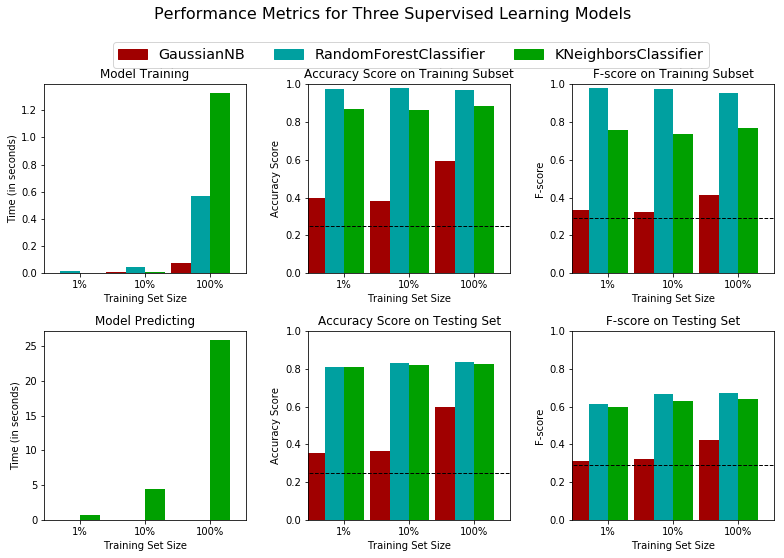

In [27]:
#  Import the three supervised learning models from sklearn

from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#  Initializing the three models
clf_A = GaussianNB()
clf_B = RandomForestClassifier(random_state=101)
clf_C = KNeighborsClassifier()

# samples_100 is the entire training, samples_10 is 10% of samples_100, samples_1 is 1% of samples_100 

samples_100 = len(y_train)
samples_10 = int(len(y_train)/10)
samples_1 = int(len(y_train)/100)

# Collecting results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Running metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, I will choose from the three supervised learning models the *best* model to use on the data. I will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

**I believe that the best of the three models I've chosen would be the random forest classifier as it has the highest F-score when testing on 10% and 100% of the data while having lower training time and a negligible predicting time compared to the second highest F-score model, also the model's accuracy and F-score are consistently high with high precision with the 3 data sizes**

### Describing the Model in Layman's Terms

**Random forest uses random parts of the data in order to create an optimum model, its' general idea is linking data cells to each other in a way that gives value based on their correlations and indirect effects in order to understand how different data would correlate with each other so it could eventually predict some of the missing data based on the existing ones** 

### Implementation: Model Tuning

In [31]:
# Importing 'GridSearchCV', 'make_scorer' libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
# Initializing the classifier
clf = RandomForestClassifier(random_state=101)

# Creating the parameters list I wish to tune.

parameters = {'n_estimators': [5,20,50,100],
'max_features': ['auto','sqrt'],
'max_depth': [int(x) for x in np.linspace(10, 120, num = 12)],
'min_samples_split': [2,6,10],
'min_samples_leaf': [1,3,4],
'bootstrap': [True,False]
             }



# Making an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score,beta=0.5)

# Performing grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf,parameters,scoring=scorer)

# Fitting the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train,y_train)

# Getting the estimator
best_clf = grid_fit.best_estimator_

# Making predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Reporting the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

Unoptimized model
------
Accuracy score on testing data: 0.8377
F-score on testing data: 0.6722

Optimized Model
------
Final accuracy score on the testing data: 0.8444
Final F-score on the testing data: 0.6859


### Final Model Evaluation

* What is the optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from the optimized model compare to the naive predictor benchmarks I found earlier?  

#### Results:

|     Metric     | Unoptimized Model | Optimized Model | Naive Predictor
| :------------: | :---------------: | :-------------: | :-------------:
| Accuracy Score |      0.8377       |    0.8444       |      0.2478
| F-score        |      0.6722       |     0.6859      |      0.2917


In [17]:
print(grid_fit.best_params_)

{'bootstrap': False, 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 100}


**An unoptimized Random forest achieved much higher accuracy score and F score than a naive predictor for the current data, the optimized model achieved 0.8% higher accuracy and an F-score that is 2% higher than the unoptimized model.**

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

### Implementation - Extracting Feature Importance

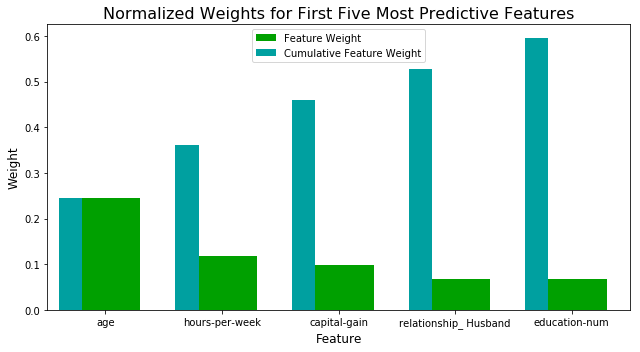

In [18]:
#  Importing a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import RandomForestClassifier

#  Training the supervised model on the training set using .fit(X_train, y_train)
model = RandomForestClassifier()
model.fit(X_train, y_train)
#  Extracting the feature importances using .feature_importances_ 
importances = importances = model.feature_importances_

# Plotting
vs.feature_plot(importances, X_train, y_train)

### Feature Selection
How does a model perform if I only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, I see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that I can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [19]:
# Importing functionality for cloning a model
from sklearn.base import clone

# Reducing the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Training on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Making new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Reporting scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8608
F-score on testing data: 0.7358

Final Model trained on reduced data
------
Accuracy on testing data: 0.8387
F-score on testing data: 0.6797


### Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would I consider using the reduced data as your training set?

|     Metric     |     Full data     | Reduced Data    | 
| :------------: | :---------------: | :-------------: |
| Accuracy Score |      0.8608       |    0.8387       |
| F-score        |      0.7358       |     0.6797      |

1- The model achieved 8% higher F-score and 2% Higher accuracy score on full data compared with the scores it achieved on reduced data.
2- If training time was a factor, ideally I would have had a prior step of comparing models, therefore if It was found that the at the time chosen model was achieving less scores on reduced data than that of another model on full data I'd chose to use the reduced data for my training set, otherwise I wouldn't.